In the "StationAnalysis.ipynb," I calculated the N of rides > 1 hour for member and casual users. But it isn't clear what percent of ALL rides these numbers represent. So this notebook will figure that information out. The goal is to figure out when we've acccount for 95% (or 99%) of all rides and can justify ignoring rides longer than X hours.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def getData(year,months=['01','02','03','04','05','06','07','08','09','10','11','12']):
    # procedure accepts year (as string) and optional list of months (strings) for which to retreive data
    # will return a df with the DIVVY data for that year and month(s)
    import pandas as pd

    if not isinstance(year,str):
        year = str(year)

    if not isinstance(months,list):
        months = [months]

    if int(year) >= 2020:
        workDir = '/home/alp/Google Drive/Python/DataSets/Data_Divvy/'
    else:
        workDir = '/home/alp/Google Drive/Python/DataSets/Data_Divvy/pre2020/'

    fileName = year + months[0] + '-divvy-tripdata.json'
    print(fileName)
    retData = pd.read_json(workDir+fileName,orient='index')

    if len(months) > 0:
        for month in months[1:]:
                fileName = year + month + '-divvy-tripdata.json'
                print(fileName)
                newData = pd.read_json(workDir+fileName,orient='index')
                retData = pd.concat([retData,newData])

    return retData

def getYear(year):
    # this will get the data for a specific year and clean it up, returning the cleaned data 
    data = getData(year)

    if int(year) < 2020:
        data.drop(columns = ['trip_id', 'bikeid', 'from_station_name',
       'to_station_name', 'gender', 'birthyear','tripduration'],inplace=True)
        data['tripduration'] = data['end_time'] - data['start_time']
        data.drop(data[data['tripduration'] < '0:00:00'].index, inplace=True)
        data['rideable_type'] = 'classic_bike'
        
    else:
        data.drop(columns=['ride_id', 'start_station_name', 'end_station_name'],inplace=True)
        data.rename(columns={'started_at':'start_time','ended_at':'end_time','member_casual':'usertype'},inplace=True)
        data['tripduration'] = data['end_time'] - data['start_time']
        data.drop(data[data['tripduration'] < '0:00:00'].index, inplace=True)
        data['rideable_type'].replace(to_replace = 'docked_bike', value = 'classic_bike',inplace = True)
    
    data['month'] = pd.DatetimeIndex(data['start_time']).month
    data['year'] = pd.DatetimeIndex(data['start_time']).year
    data['usertype'].replace(['Subscriber','Customer'],['member','casual'],inplace = True)

    if 'from_station_id' in data.columns:
        data.rename(columns={'from_station_id':'start_station_id','to_station_id':'end_station_id'},inplace=True)
    
    return data

In [3]:
#bigData = pd.concat([getYear('2019'),getYear('2020'),getYear('2021')],axis=0)
bigData = getYear('2021')

202101-divvy-tripdata.json
202102-divvy-tripdata.json
202103-divvy-tripdata.json
202104-divvy-tripdata.json
202105-divvy-tripdata.json
202106-divvy-tripdata.json
202107-divvy-tripdata.json
202108-divvy-tripdata.json
202109-divvy-tripdata.json
202110-divvy-tripdata.json
202111-divvy-tripdata.json
202112-divvy-tripdata.json


In [4]:
bigData.shape


(5593819, 13)

In [5]:
bigData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12883947 entries, 0 to 247539
Data columns (total 13 columns):
 #   Column            Dtype          
---  ------            -----          
 0   start_time        datetime64[ns] 
 1   end_time          datetime64[ns] 
 2   start_station_id  object         
 3   end_station_id    object         
 4   usertype          object         
 5   start_lat         float64        
 6   start_lng         float64        
 7   end_lat           float64        
 8   end_lng           float64        
 9   tripduration      timedelta64[ns]
 10  rideable_type     object         
 11  month             int64          
 12  year              int64          
dtypes: datetime64[ns](2), float64(4), int64(2), object(4), timedelta64[ns](1)
memory usage: 1.3+ GB


In [26]:
def pctLongRides(cutoff,mTemp,cTemp,mTotal, cTotal):
    # input - cutoff = hour value - how many rides were N hours long (2-3, 3-4, etc)
    # mTemp, cTemp = dfs with the values for member and customers
    # mTotal, cTotal = the N of all rides for each user category
    #
    # output: the number of rides of a given time duration for M and C users, as well as the percent of all rides each represents
    mLong = mTemp[(mTemp['tripduration'] > pd.Timedelta(cutoff  ,unit='h') ) &
                    (mTemp['tripduration'] < pd.Timedelta(cutoff+1,unit='h') ) ]
    #mStartFin = mLong.loc[ (mLong['start_lat'] == mLong['end_lat']) & (mLong['start_lng'] == mLong['end_lng']) ]
    #the StartFin number shows the N of bikes taken and returned to the same station, a use pattern that might be common for tourists

    cLong = cTemp[(cTemp['tripduration'] > pd.Timedelta(cutoff  ,unit='h') ) &
                    (cTemp['tripduration'] < pd.Timedelta(cutoff+1,unit='h') ) ]
    #cStartFin = cLong.loc[ (cLong['start_lat'] == cLong['end_lat']) & (cLong['start_lng'] == cLong['end_lng']) ]

#    return len(mLong), round(len(mLong)/mTotal,3), len(cLong), round(len(cLong)/cTotal,3)
    return len(mLong), len(mLong)/mTotal, len(cLong), len(cLong)/cTotal


In [16]:
bigData['usertype'].value_counts()

member        5195977
casual        3870005
Subscriber    2937340
Customer       880625
Name: usertype, dtype: int64

In [17]:
bigData['usertype'].replace(['Subscriber','Customer'],['member','casual'],inplace = True)

In [18]:
bigData['usertype'].value_counts()

member    8133317
casual    4750630
Name: usertype, dtype: int64

In [36]:
mTemp = bigData[bigData['usertype']=='member']
cTemp = bigData[bigData['usertype']=='casual']

hours = []
NmLong, pctMLong, NcLong, pctCLong  = [],[],[],[]
for i in range(1,8):
    a,b,c,d = pctLongRides(i,mTemp,cTemp,len(mTemp),len(cTemp))
    hours.append(i)
    NmLong.append(a)
    pctMLong.append(b*100)
    NcLong.append(c)
    pctCLong.append(d*100)

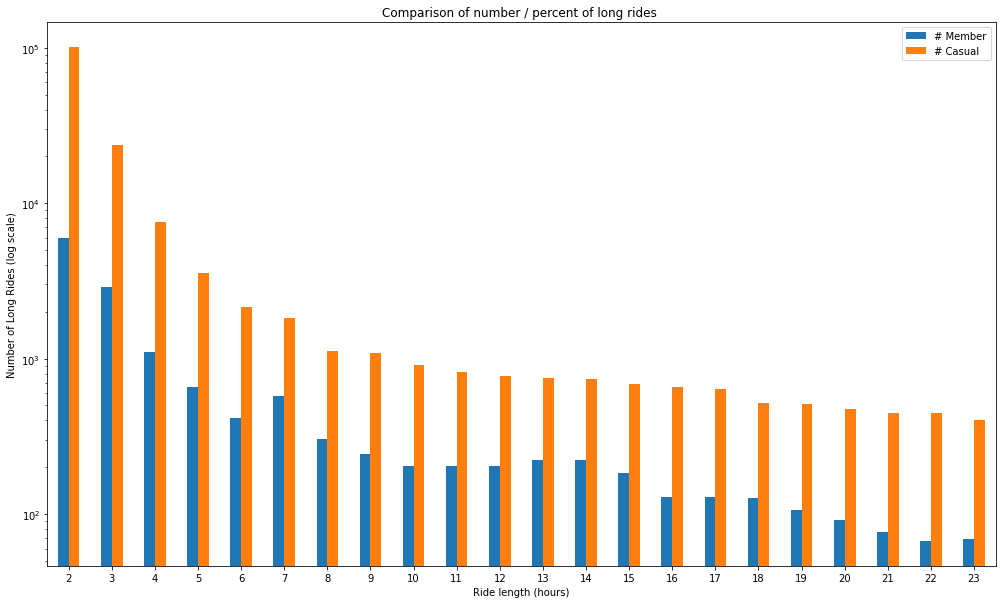

In [21]:
compare = pd.DataFrame({
    '# Member'  : NmLong,
    '% Member': pctMLong,
    '# Casual'  : NcLong,
    '% Casual': pctCLong
})

#ax = plt.gca()
ax = compare[['# Member','# Casual']].plot(kind = 'bar',figsize=(17,10))
plt.ylabel('Number of Long Rides (log scale)')
plt.yscale('log')
compare[['% Member','% Casual']].plot(kind = 'line',secondary_y = True,ax=ax)
plt.ylabel('Percent of long rides')

ax.set_xticklabels(hours)
plt.xticks(rotation=0,horizontalalignment = 'center')
plt.xlabel('Ride length (hours)')
title = 'Comparison of number / percent of long rides '
plt.title(title)

ax.grid(axis='y')
plt.show()

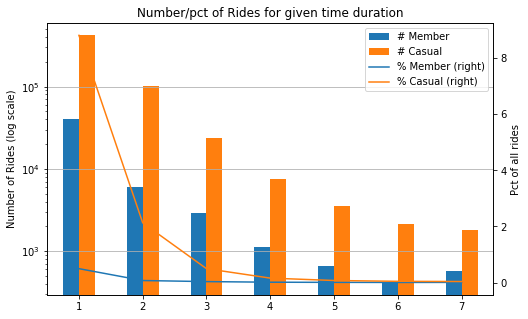

In [42]:
compare = pd.DataFrame({
    '# Member'  : NmLong,
    '% Member': pctMLong,
    '# Casual'  : NcLong,
    '% Casual': pctCLong
})

#ax = plt.gca()
ax = compare[['# Member','# Casual']].plot(kind = 'bar',figsize=(8,5))
plt.ylabel('Number of Rides (log scale)')
plt.yscale('log')
compare[['% Member','% Casual']].plot(kind = 'line',secondary_y = True,ax=ax)
plt.ylabel('Pct of all rides')

ax.set_xticklabels(hours)
plt.xticks(rotation=0,horizontalalignment = 'center')
plt.xlabel('Ride length (hours)')

title = 'Number/pct of Rides for given time duration'
plt.title(title)

ax.grid(axis='y')
plt.show()

In [38]:
compare

,# Member,% Member,# Casual,% Casual
0,40369,0.496341,418511,8.809589
1,5964,0.073328,101215,2.130560
2,2889,0.035521,23561,0.495955
3,1106,0.013598,7582,0.159600
4,654,0.008041,3534,0.074390
5,416,0.005115,2149,0.045236
6,578,0.007107,1822,0.038353


The above routine calculates the N & pct of rides in a given range. It isn't clear how what the cumulative values are. That is, at what point are 99% of rides accounted for?

To determine this, let's look at the cumulative values. How many rides are greater than 1? than 2? than 3? This means that we will double count: the N > 1 will be the sum of all the values >2, plus the interval of 1-2. Still, this cumulative calucation makes it easier to see when we've got to a 99% value.

In [43]:
def pctLongRidesCumulative(cutoff,mTemp,cTemp,mTotal, cTotal):
    # input - cutoff = hour value - how many rides were N hours long (2-3, 3-4, etc)
    # mTemp, cTemp = dfs with the values for member and customers
    # mTotal, cTotal = the N of all rides for each user category
    #
    # output: the number of rides of a given time duration for M and C users, as well as the percent of all rides each represents
    mLong = mTemp[(mTemp['tripduration'] > pd.Timedelta(cutoff  ,unit='h') ) ]
    cLong = cTemp[(cTemp['tripduration'] > pd.Timedelta(cutoff  ,unit='h') ) ]
    
    return len(mLong), len(mLong)/mTotal, len(cLong), len(cLong)/cTotal

hours = []
NmLong, pctMLong, NcLong, pctCLong  = [],[],[],[]
for i in range(1,8):
    a,b,c,d = pctLongRidesCumulative(i,mTemp,cTemp,len(mTemp),len(cTemp))
    hours.append(i)
    NmLong.append(a)
    pctMLong.append(b*100)
    NcLong.append(c)
    pctCLong.append(d*100)

compare = pd.DataFrame({
    '# Member'  : NmLong,
    '% Member': pctMLong,
    '# Casual'  : NcLong,
    '% Casual': pctCLong
})

compare

,# Member,% Member,# Casual,% Casual
0,55897,0.687260,576853,12.142663
1,15527,0.190906,158291,3.332000
2,9563,0.117578,57065,1.201209
3,6674,0.082058,33501,0.705191
4,5567,0.068447,25918,0.545570
5,4913,0.060406,22383,0.471159
6,4496,0.055279,20234,0.425922


In [48]:
100-0.687

99.313

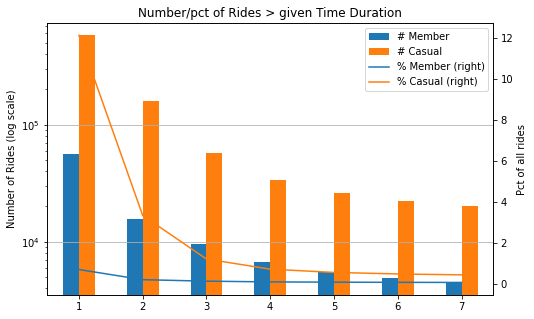

In [46]:
ax = compare[['# Member','# Casual']].plot(kind = 'bar',figsize=(8,5))
plt.ylabel('Number of Rides (log scale)')
plt.yscale('log')
compare[['% Member','% Casual']].plot(kind = 'line',secondary_y = True,ax=ax)
plt.ylabel('Pct of all rides')

ax.set_xticklabels(hours)
plt.xticks(rotation=0,horizontalalignment = 'center')
plt.xlabel('Ride length (hours)')

title = 'Number/pct of Rides > given Time Duration'
plt.title(title)

ax.grid(axis='y')
plt.show()

How many cascual users take advantage of Divvy's 30 minute ride option?

In [51]:
ridesLess30Min = len(cTemp[(cTemp['tripduration'] > pd.Timedelta(0.5  ,unit='h') ) ])
print(ridesLess30Min,ridesLess30Min/len(cTemp)*100)

1442129 30.356584284610673


In [58]:
bigData['year'].value_counts()

2021    5593819
2019    3817965
2020    3472163
Name: year, dtype: int64

In [61]:
for year in [2019,2020,2021]:
    tempDF = bigData[bigData['year'] == year]
    print(year,tempDF[tempDF['usertype'] == 'casual']['tripduration'].describe())


2019 count                       880625
mean     0 days 00:57:01.095361816
std      0 days 15:27:00.303666046
min                0 days 00:01:01
25%                0 days 00:15:15
50%                0 days 00:25:50
75%                0 days 00:45:18
max              123 days 01:20:22
Name: tripduration, dtype: object
2020 count                      1341547
mean     0 days 00:47:25.715686442
std      0 days 08:19:58.810059402
min                0 days 00:00:00
25%                0 days 00:11:46
50%                0 days 00:21:33
75%                0 days 00:40:49
max              108 days 15:30:24
Name: tripduration, dtype: object
2021 count                      2528458
mean     0 days 00:32:00.191934768
std      0 days 04:23:10.302644419
min                0 days 00:00:00
25%                0 days 00:09:04
50%                0 days 00:15:58
75%                0 days 00:29:17
max               38 days 20:24:09
Name: tripduration, dtype: object


In [62]:
for year in [2019,2020,2021]:
    tempDF = bigData[bigData['year'] == year]
    print(year,tempDF[tempDF['usertype'] == 'member']['tripduration'].describe())

2019 count                      2937340
mean     0 days 00:14:19.668302273
std      0 days 04:12:24.351861691
min                0 days 00:01:01
25%                0 days 00:06:02
50%                0 days 00:09:48
75%                0 days 00:16:07
max              104 days 19:43:54
Name: tripduration, dtype: object
2020 count                      2130616
mean     0 days 00:15:44.893617620
std      0 days 02:11:51.379146211
min                0 days 00:00:00
25%                0 days 00:06:21
50%                0 days 00:11:06
75%                0 days 00:19:26
max               65 days 03:13:31
Name: tripduration, dtype: object
2021 count                      3065361
mean     0 days 00:13:38.015933523
std      0 days 00:27:42.448698235
min                0 days 00:00:00
25%                0 days 00:05:34
50%                0 days 00:09:36
75%                0 days 00:16:36
max                1 days 01:59:56
Name: tripduration, dtype: object


In [6]:
bigData['rideable_type'].value_counts()

classic_bike     6538112
electric_bike    2527870
Name: rideable_type, dtype: int64